# INITIALIZATION

In [25]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from mango import Mango,MangoEnvironment
from abstraction import StateAbstractor, AbstractionBuffer
from policies import PolicyStack,QnetPolicy
from actions import *
from states import *

# Environment

In [64]:
class Environment():
    def __init__(self, size=(8,8)):
        self.max_x,self.max_y = size
        self.reset()
        self.actionspace = [torch.tensor([[a]]) for a in range(4)]
    
    def reset(self):
        self.x, self.y = np.random.randint(self.max_x),np.random.randint(self.max_y)
        self.path = [(self.x, self.y)]
        return self.get_state()
    
    def get_state(self):
        state = torch.zeros((self.max_x,self.max_y))
        state[self.x,self.y] = 1
        return torch.Tensor(state)
        
    def step(self,action):
        if action.item() == 0:
            self.x = min((max((self.x+1, 0)),self.max_x-1))
        if action.item() == 1:
            self.y = min((max((self.y+1, 0)),self.max_y-1))
        if action.item() == 2:
            self.x = min((max((self.x-1, 0)),self.max_x-1))
        if action.item() == 3:
            self.y = min((max((self.y-1, 0)),self.max_y-1))
        self.path.append((self.x,self.y))
        return self.get_state(), "reward", "terminated", "truncated"
    
    def render(self):
        plt.imshow(self.get_state())
        for (x0,y0),(x1,y1) in zip(self.path,self.path[1:]):
            plt.plot((y0,y1),(x0,x1),"-r")
        x0,y0 = self.path[0]
        plt.plot(y0,x0,"xr")

# Abstractor

In [65]:
class ZoomOutStateAbstractor(StateAbstractor):
    def __init__(self,k):
        super().__init__()
        self.k=k
        
    def abstract(self, state):
        kx,ky = self.k
        state = state.repr
        state_prime = torch.zeros(((state.shape[0]//kx,state.shape[1]//ky)))
        for x in range(state_prime.shape[0]):
            for y in range(state_prime.shape[1]):
                state_prime[x,y] = torch.sum(state[kx*x:kx*x+kx,ky*y:ky*y+ky])
        return TensorState(state_prime)  

# Policy

In [66]:
class SimpleNet(torch.nn.Module):
    def __init__(self, shape, out):
        super().__init__()
        self.layer = torch.nn.Linear(shape[0]*shape[1],out)
        #self.layer = torch.nn.Parameter(torch.zeros(out))
        
    def forward(self,x):
        #return torch.stack([self.layer for _ in x])
        x = torch.flatten(x,start_dim=1)
        x = self.layer(x)
        return x

# Test MANGO

torch.Size([25, 25])
torch.Size([5, 5])


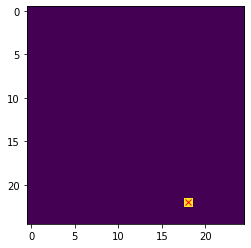

In [78]:
envshape = (25,25)
mangoenv = MangoEnvironment(Environment(envshape),TensorState,TensorAction)
mangochain = [mangoenv]
stateshape = mangochain[-1].get_current_state()[1].repr.shape

for i in range(2):
    abstractor = ZoomOutStateAbstractor((5,5))
    stateshape = mangochain[-1].get_current_state()[1].repr.shape
    print(stateshape)
    policystack = PolicyStack(QnetPolicy(SimpleNet(stateshape,5)),layer=1, capacity = 1000, batch_size = 256)
    mangochain.append(Mango(mangochain[-1], policystack, abstractor, layer=len(mangochain)))
    
mangochain[0].env.render()

## Explore

  0%|          | 0/10 [00:00<?, ?it/s]

discovered new action [ACTION up layer1]
discovered new action [ACTION down layer1]
discovered new action [ACTION left layer1]
discovered new action [ACTION right layer1]


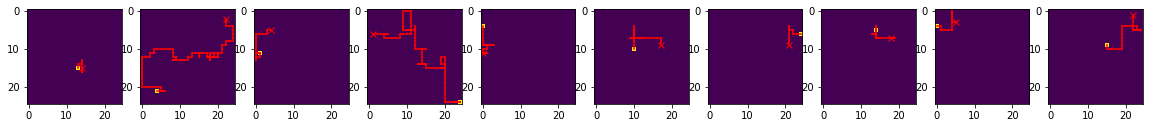

In [79]:
plt.figure(figsize=(20,10))
n=10
for i in tqdm(range(n)):
    plt.subplot(n//10,10,i+1)
    mangochain[-1].reset_env()
    comand = mangochain[-1].learned_comands()[0]
    state_prime = mangochain[-1].handle_abstract_action(comand)
    mangochain[0].env.render()

In [80]:
for i,mango in enumerate(mangochain):
    print(f"MANGO {i}")
    for c in mango.learned_comands() :
        print(f"learned command: {str(c)}")
    print()

MANGO 0
learned command: [ACTION tensor([[0]]) layerNone]
learned command: [ACTION tensor([[1]]) layerNone]
learned command: [ACTION tensor([[2]]) layerNone]
learned command: [ACTION tensor([[3]]) layerNone]

MANGO 1
learned command: [ACTION EXPLORE layer1]
learned command: [ACTION up layer1]
learned command: [ACTION down layer1]
learned command: [ACTION left layer1]
learned command: [ACTION right layer1]

MANGO 2
learned command: [ACTION EXPLORE layer1]



## eval comandsmangochain

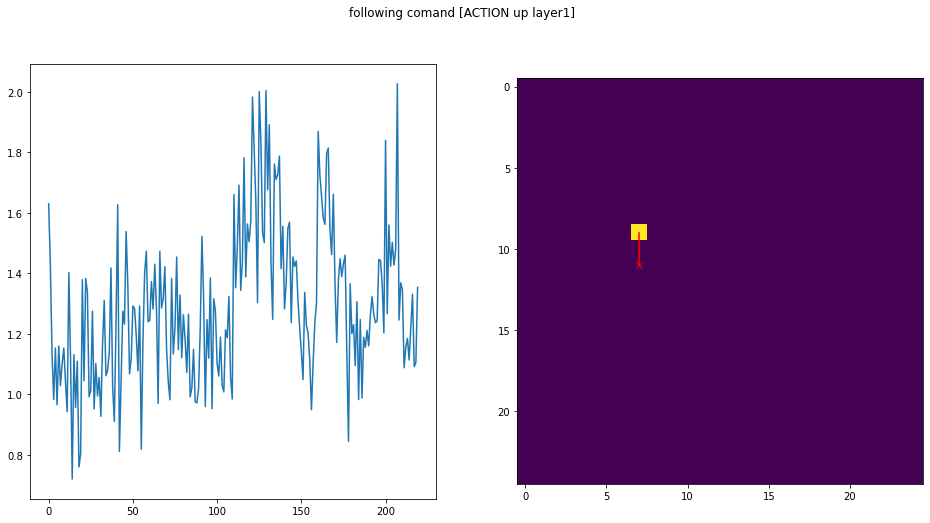

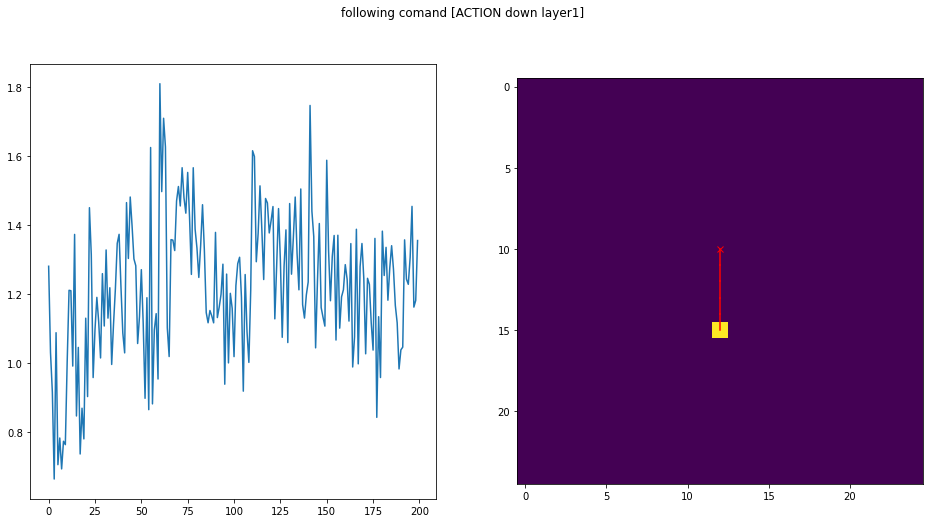

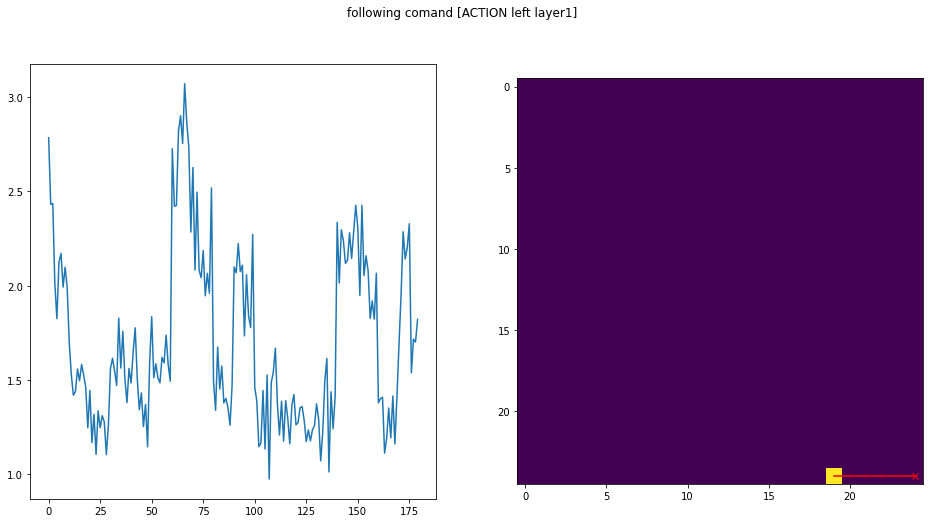

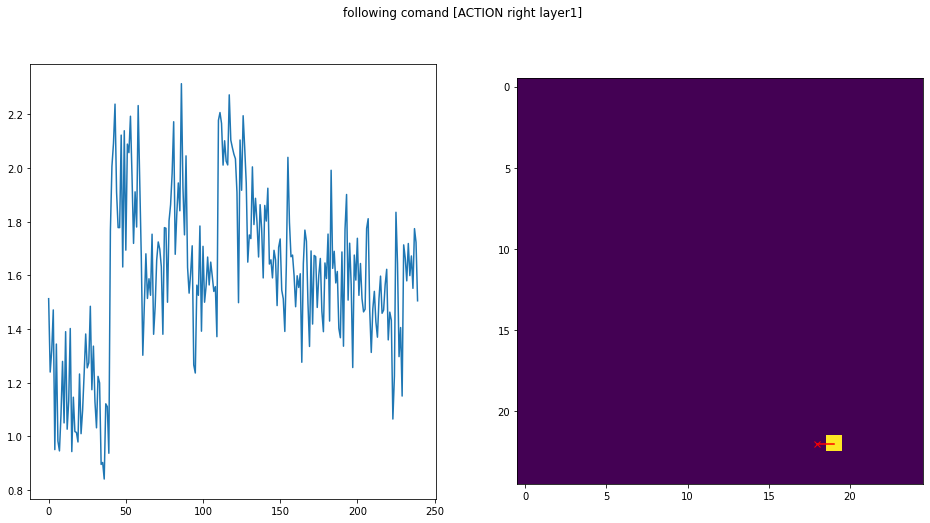

In [81]:
for i,(comand,policy) in enumerate(mangochain[-2].policy_stack.items()):
    if i>=1:
        plt.figure(figsize=(16,8))
        plt.suptitle(f"following comand {comand}")
        plt.subplot(121)
        plt.plot(policy.losses)
        #print(comand,policy.Q_net.layer)
        plt.subplot(122)
        mangochain[-1].reset_env()
        mangochain[-2].handle_abstract_action(comand)
        mangochain[0].env.render()